In this group of notebook we will test the methods implemented in the library to check if they can improve the results of the models.

In order to be as impartial as possible, we will use a KFold evaluation for each combination, with a k-value of five.

In this particular notebook, we will train the vanilla model: its results will be the base results of our study.

In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from vision_models_evaluation.core import evaluate

from sklearn.model_selection import KFold

import pandas as pd

import PIL
import torchvision.transforms as transforms
from pathlib import Path
import random

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Then, we prepare the scenario: we are going to use a grape vine dataset where the semantic problem to tackle is to segmentate the RGB images into wood, leaves, grape and pole classes.

Finally, we define here the mapping functions and the masks transformations.

In [2]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"

def get_y_fn (x):
    return Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))

codes = np.loadtxt(path/'codesAll.txt', dtype=str)

def ParentSplitter(x):
    return Path(x).parent.name==test_name

from albumentations import (
  Compose,
  OneOf,
  ElasticTransform,
  GridDistortion, 
  OpticalDistortion,
  HorizontalFlip,
  Rotate,
  Transpose,
  CLAHE,
  ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0

    def __init__(self, aug): 
        self.aug = aug

    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

transforms=Compose([HorizontalFlip(p=0.5),
                    Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transforms)

class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x

        #Convert to array
        mask = np.array(mask)

        # background = 0, leaves = 1, pole = 74 o 76, wood = 25 o 29, grape = 255
        mask[mask == 255] = 1 # grape
        mask[mask == 150] = 2 # leaves
        mask[mask == 76] = 3 ; mask[mask == 74] = 3 # pole
        mask[mask == 29] = 4 ; mask[mask == 25] = 4 # wood
        mask[mask >= 5] = 0 # resto: background

        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

While training, we will use the EarlyStopping strategy: after five epoch without improvements, the training will be stopped.

In [3]:
cbs = [
    EarlyStoppingCallback(patience = 5, min_delta = 0.01),
]

Then, we define all the hparams (hyperparameters) to build the datablocks, dataloaders and learners.

In [4]:
db_hparams = {
    "blocks": (ImageBlock, MaskBlock(codes)),
    "get_items": get_image_files,
    "get_y": get_y_fn,
    "splitter": RandomSplitter(valid_pct=0.2),
    "item_tfms": [Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
    "batch_tfms": Normalize.from_stats(*imagenet_stats)
}

dls_hparams = {
    "source": path_images,
    "bs": 2,
    "pin_memory": False
}

technique = KFold(n_splits = 5)

learner_hparams = {
    "arch": resnet50,
    "pretrained": True,
    "metrics": [DiceMulti()],
    "cbs": cbs
}

learning_hparams = {
    "epochs": 30,
    "base_lr": 0.001,
    "freeze_epochs": 3
}

learning_mode = "finetune"

Finally, we test the base model.

In [5]:
r = evaluate(db_hparams, dls_hparams, technique, learner_hparams, learning_hparams, learning_mode)

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torch/_tensor.py:1121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and

epoch,train_loss,valid_loss,dice_multi,time
0,0.841000,0.539658,0.335579,00:22
1,0.623032,0.747039,0.315586,00:20
2,0.614862,0.530540,0.442778,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.370598,0.345648,0.627512,00:21
1,0.344172,0.356767,0.605286,00:21
2,0.324328,0.331518,0.641760,00:20
3,0.316891,0.330881,0.676096,00:21
4,0.309702,0.319963,0.732067,00:21
5,0.299163,0.310342,0.749306,00:21
6,0.289477,0.355583,0.778525,00:20
7,0.288105,0.309319,0.741029,00:20
8,0.285260,0.300240,0.726640,00:20
9,0.273005,0.295981,0.774562,00:19


No improvement since epoch 10: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.861776,0.603098,0.333901,00:21
1,0.668912,0.707893,0.285769,00:20
2,0.895203,0.853508,0.266637,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.552743,0.420729,0.378422,00:21
1,0.483285,0.434831,0.399522,00:20
2,0.427816,0.329896,0.639819,00:20
3,0.389150,0.359369,0.637703,00:21
4,0.364362,0.311199,0.677764,00:21
5,0.357863,0.429572,0.600415,00:21
6,0.360261,0.291934,0.695458,00:21
7,0.337005,0.281972,0.760932,00:21
8,0.314879,0.261119,0.801332,00:22
9,0.313736,0.296910,0.753140,00:22


No improvement since epoch 13: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.159527,0.841137,0.250838,00:20
1,0.766592,0.464116,0.352940,00:21
2,0.785115,1.054243,0.134324,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.646229,0.447685,0.454407,00:21
1,0.497901,0.387442,0.524032,00:21
2,0.441976,0.384128,0.525914,00:21
3,0.396523,0.326396,0.701543,00:20
4,0.358334,0.288563,0.764968,00:21
5,0.328568,0.333725,0.703177,00:21
6,0.310225,0.313194,0.725879,00:21
7,0.306140,0.277647,0.754864,00:21
8,0.306006,0.306818,0.776462,00:21
9,0.292310,0.279851,0.800791,00:21


No improvement since epoch 7: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.274639,0.900757,0.288933,00:21
1,0.840692,0.388148,0.360148,00:20
2,0.642998,0.336636,0.372569,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.420241,0.284378,0.624606,00:21
1,0.374099,0.249451,0.744891,00:21
2,0.352833,0.267564,0.615602,00:21
3,0.327738,0.254552,0.804138,00:20
4,0.318560,0.252408,0.771494,00:20
5,0.316868,0.253996,0.780192,00:20
6,0.313362,0.238031,0.820259,00:21
7,0.302669,0.231940,0.812867,00:20
8,0.300345,0.233362,0.818298,00:21
9,0.283577,0.213328,0.836536,00:21


No improvement since epoch 9: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.856319,0.557122,0.342354,00:21
1,0.652636,0.605469,0.374589,00:21
2,0.733814,1.030573,0.233790,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.599385,0.470273,0.389842,00:21
1,0.480260,0.399222,0.409054,00:21
2,0.419119,0.381482,0.554553,00:21
3,0.387691,0.367401,0.698022,00:20
4,0.354128,0.346824,0.720860,00:21
5,0.336776,0.286014,0.723622,00:21
6,0.322037,0.295588,0.767174,00:21
7,0.311016,0.288814,0.778493,00:21
8,0.299037,0.278066,0.804272,00:21
9,0.282147,0.258664,0.822323,00:21


No improvement since epoch 9: early stopping


And plot the results.

In [6]:
df = pd.DataFrame(r)
df

,validation,DiceMulti
0,0.205041,0.847327
1,0.190574,0.853094
2,0.192151,0.842115
3,0.181299,0.858691
4,0.237079,0.793068


<AxesSubplot: >

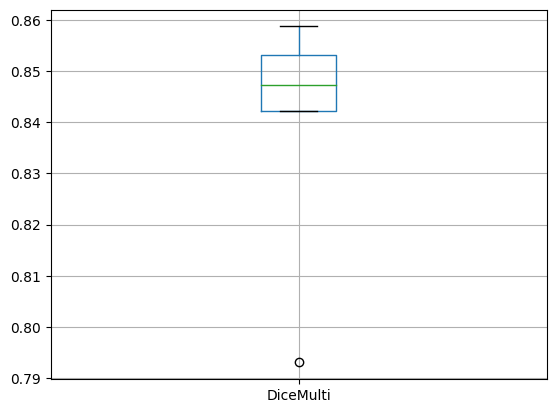

In [7]:
df.boxplot("DiceMulti")

We will show its mean and standar deviation too.

In [8]:
df.describe().transpose()[["mean", "std"]]

,mean,std
validation,0.201229,0.021754
DiceMulti,0.838859,0.026340
